<a href="https://colab.research.google.com/github/fakeprogrammer/docker_firefox_on_jammy/blob/main/Julia_Colab_Notebook_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.11.3" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia Base64 Plots Distributions KernelDensity Printf Random Roots Statistics StatsFuns StatsPlots SymPy SpecialFunctions QuadGK PyCall PyPlot FiniteDifferences BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz
  # Add julia to PATH so the 'which julia' command can find it
  # export PATH="/usr/local/julia-$JULIA_VERSION/bin:$PATH"

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  # if [ $GPU -eq 1 ]; then
  #   JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  # fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    # julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
    julia -e 'using Pkg; Pkg.add("'"$PKG"'"); precompile;' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.11.3 on the current Colab Runtime...
2025-03-02 09:42:03 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.11/julia-1.11.3-linux-x86_64.tar.gz [266111465/266111465] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [ ]:
versioninfo()

Julia Version 1.11.3
Commit d63adeda50d (2025-01-21 19:42 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × AMD EPYC 7B12
  WORD_SIZE: 64
  LLVM: libLLVM-16.0.6 (ORCJIT, znver2)
Threads: 2 default, 0 interactive, 1 GC (on 2 virtual cores)
Environment:
  LD_LIBRARY_PATH = /usr/local/nvidia/lib:/usr/local/nvidia/lib64
  JULIA_NUM_THREADS = 2


In [ ]:
ENV["COLUMNS"] = 200

using Distributions
using FiniteDifferences
using LinearAlgebra: I, eigen
using Random
using Roots
using StatsPlots
default(fmt=:png, titlefontsize=10, plot_titlefontsize=12)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed FiniteDifferences ─ v0.12.32
   Installed Richardson ──────── v1.4.2
    Updating `~/.julia/environments/v1.11/Project.toml`
  [26cc04aa] + FiniteDifferences v0.12.32
    Updating `~/.julia/environments/v1.11/Manifest.toml`
  [26cc04aa] + FiniteDifferences v0.12.32
  [708f8203] + Richardson v1.4.2
Precompiling project...
    808.1 ms  ✓ Richardson
   1403.3 ms  ✓ FiniteDifferences
  2 dependencies successfully precompiled in 3 seconds. 290 already precompiled.


In [ ]:
function plot_poi(; λ=20, kwargs...)
    poi = Poisson(λ)
    normal = Normal(λ, √λ)
    bar(poi; alpha=0.3, label="Poisson($λ)")
    plot!(normal; label="Normal(
λ)", lw=2)
    plot!(; xlim=(λ-4√λ, λ+4√λ), kwargs...)
end

plot_poi (generic function with 1 method)

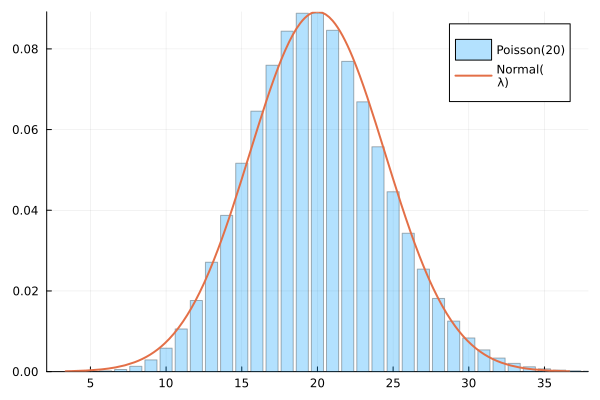

In [ ]:
plot_poi(; λ=20)

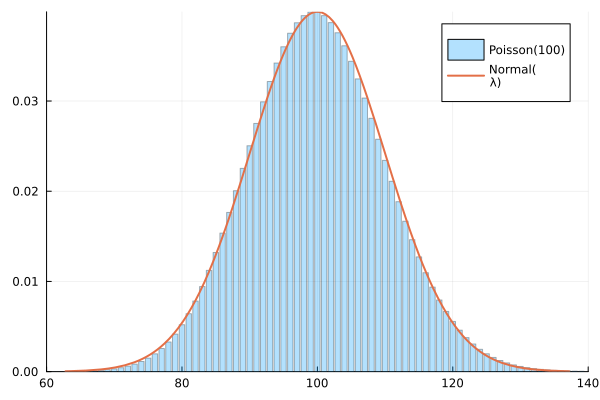

In [ ]:
plot_poi(; λ=100)

In [ ]:
function plot_sqmahal(mvn::MvNormal; L=10^6)
    d = length(mvn)
    MSq = zeros(L)
    Xtmp = [zeros(d) for _ in 1:Threads.nthreads()]
    Threads.@threads for i in 1:L
        tid = Threads.threadid()
        X = rand!(mvn, Xtmp[tid])
        MSq[i] = sqmahal(mvn, X)
    end
    stephist(MSq; norm=true, label="squared Mahalanobis")
    plot!(Chisq(d), extrema(MSq)...; label="Chisq($d)", ls=:dash)
end

function plot_rand_sqmahal(;
        d = rand(5:15),
        μ = round.(10randn(d); sigdigits=3),
        Σ = round.(rand(Wishart(30.0, 0.1Matrix{Float64}(I, d, d))); sigdigits=3),
        L = 10^6)
    @show d
    @show μ
    print("Σ = "); display(Σ)
    mvn = MvNormal(μ, Σ)
    plot_sqmahal(mvn; L)
end

plot_rand_sqmahal (generic function with 1 method)

d = 8
μ = [6.86, 18.0, -7.99, 6.12, 30.7, 12.7, -1.84, 7.02]
Σ = 

8×8 Matrix{Float64}:
  3.22     -0.00116  -0.35    0.12    -0.616   -0.61   -0.113   0.399
 -0.00116   2.52     -0.252   0.209    0.0891  -0.672   0.227  -0.424
 -0.35     -0.252     3.99   -0.361    0.938    1.05   -0.964  -0.235
  0.12      0.209    -0.361   2.27     0.0681   0.283   0.539   0.159
 -0.616     0.0891    0.938   0.0681   2.37     0.125  -0.494  -0.387
 -0.61     -0.672     1.05    0.283    0.125    3.92    0.351   0.463
 -0.113     0.227    -0.964   0.539   -0.494    0.351   2.88    0.55
  0.399    -0.424    -0.235   0.159   -0.387    0.463   0.55    1.78

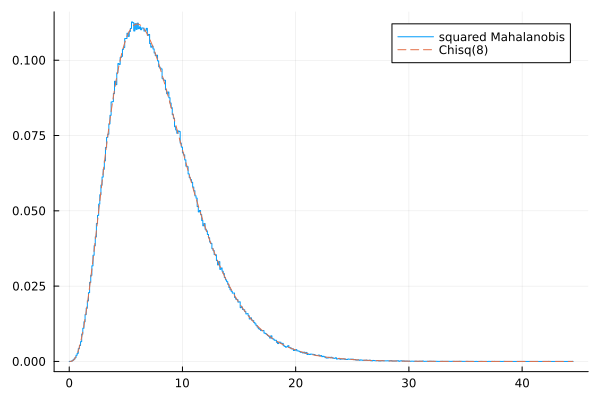

In [ ]:
plot_rand_sqmahal()

In [ ]:
function plot_mult(; n=20, p=[0.2, 0.3, 0.5])
    mult = Multinomial(n, p)
    prob = [x+y ≤ n ? pdf(mult, [x, y, n-x-y]) : NaN for x in 0:n, y in 0:n]
    P = heatmap(0:n, 0:n, prob; label="", colorbar=false)
    title!("Multinomial(
p)")

    μ = mean(mult)[1:2]
    Σ = cov(mult)[1:2, 1:2]
    mvn = MvNormal(μ, Σ)
    xs = range(0, n, 400)
    ys = range(0, n, 400)
    den = [x+y ≤ n ? pdf(mvn, [x, y]) : NaN for x in xs, y in ys]
    Q = heatmap(xs, ys, den; label="", colorbar=false)
    title!("MvNormal(
(round.(Σ; digits=2)))")

    plot(P, Q; size=(800, 400))
end

plot_mult (generic function with 1 method)

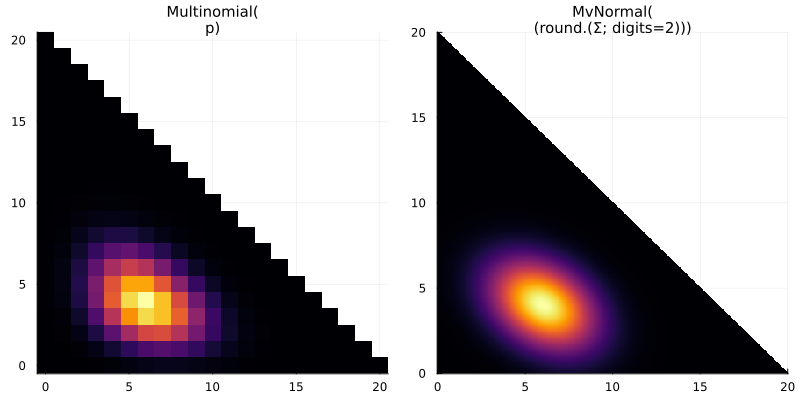

In [ ]:
plot_mult(; n=20, p=[0.2, 0.3, 0.5])

In [ ]:
using BenchmarkTools

M = rand(2^11, 2^11)

@btime $M * $M;

In [ ]:
try
    using CUDA
catch
    println("No GPU found.")
else
    run(`nvidia-smi`)
    # Create a new random matrix directly on the GPU:
    M_on_gpu = CUDA.CURAND.rand(2^11, 2^11)
    @btime $M_on_gpu * $M_on_gpu; nothing
end

# Need Help?

* Learning: https://julialang.org/learning/
* Documentation: https://docs.julialang.org/
* Questions & Discussions:
  * https://discourse.julialang.org/
  * http://julialang.slack.com/
  * https://stackoverflow.com/questions/tagged/julia

If you ever ask for help or file an issue about Julia, you should generally provide the output of `versioninfo()`.

In [ ]:
using Base.MathConstants
using Base64
using Printf
using Statistics
const e = ℯ
endof(a) = lastindex(a)
linspace(start, stop, length) = range(start, stop, length=length)

using Plots
#gr(); ENV["PLOTS_TEST"] = "true"
#clibrary(:colorcet)
#clibrary(:misc)
default(fmt=:png)

function pngplot(P...; kwargs...)
    sleep(0.1)
    pngfile = tempname() * ".png"
    savefig(plot(P...; kwargs...), pngfile)
    showimg("image/png", pngfile)
end
pngplot(; kwargs...) = pngplot(plot!(; kwargs...))

showimg(mime, fn) = open(fn) do f
    base64 = base64encode(f)
    display("text/html", """<img src="data:$mime;base64,$base64">""")
end

using SymPy
#sympy.init_printing(order="lex") # default
#sympy.init_printing(order="rev-lex")

using SpecialFunctions
using QuadGK

# Override the Base.show definition of SymPy.jl:
# https://github.com/JuliaPy/SymPy.jl/blob/29c5bfd1d10ac53014fa7fef468bc8deccadc2fc/src/types.jl#L87-L105

@eval SymPy function Base.show(io::IO, ::MIME"text/latex", x::SymbolicObject)
    print(io, as_markdown("\\displaystyle " * sympy.latex(x, mode="plain", fold_short_frac=false)))
end
@eval SymPy function Base.show(io::IO, ::MIME"text/latex", x::AbstractArray{Sym})
    function toeqnarray(x::Vector{Sym})
        a = join(["\\displaystyle " * sympy.latex(x[i]) for i in 1:length(x)], "\\\\")
        """\\left[ \\begin{array}{r}$a\\end{array} \\right]"""
    end
    function toeqnarray(x::AbstractArray{Sym,2})
        sz = size(x)
        a = join([join("\\displaystyle " .* map(sympy.latex, x[i,:]), "&") for i in 1:sz[1]], "\\\\")
        "\\left[ \\begin{array}{" * repeat("r",sz[2]) * "}" * a * "\\end{array}\\right]"
    end
    print(io, as_markdown(toeqnarray(x)))
end

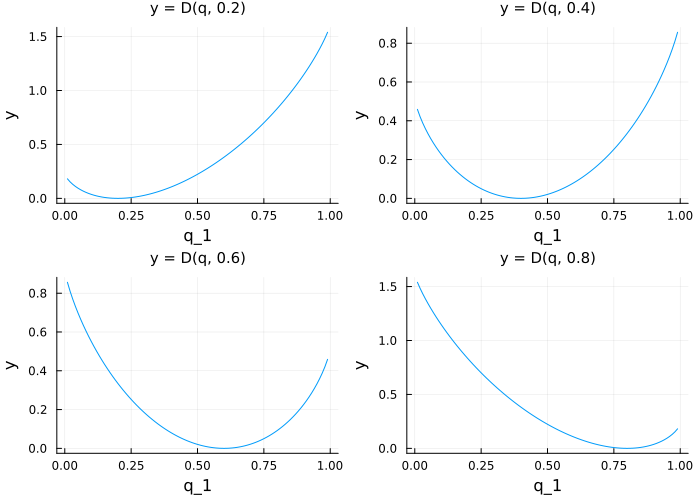

In [ ]:
D(q,p) = q*log(q/p) + (1-q)*log((1-q)/(1-p))
q = 0:0.01:1
PP = []
for p in [0.2, 0.4, 0.6, 0.8]
    P = plot(legend=false)
    plot!(title="y = D(q, $(round(p,digits=3)))", titlefontsize=10)
    plot!(xlabel="q_1", ylabel="y")
    plot!(q, D.(q, p))
    push!(PP, P)
end
plot(PP..., size=(700, 500))

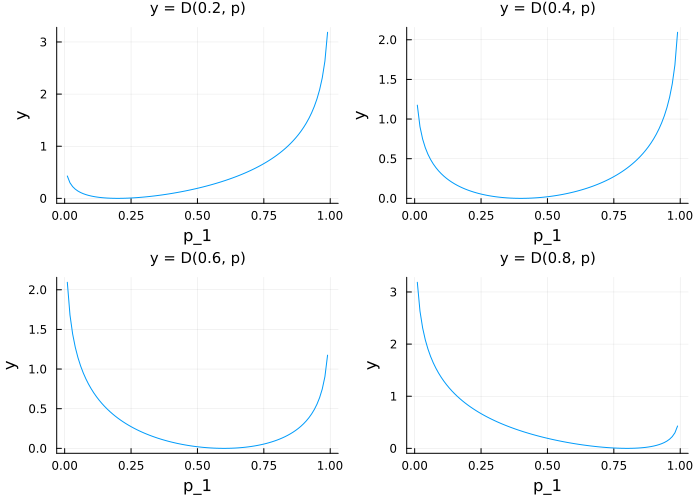

In [ ]:
D(q,p) = q*log(q/p) + (1-q)*log((1-q)/(1-p))
p = 0:0.01:1
PP = []
for q in [0.2, 0.4, 0.6, 0.8]
    P = plot(legend=false)
    plot!(title="y = D($(round(q,digits=3)), p)", titlefontsize=10)
    plot!(xlabel="p_1", ylabel="y")
    plot!(p, D.(q, p))
    push!(PP, P)
end
plot(PP..., size=(700, 500))

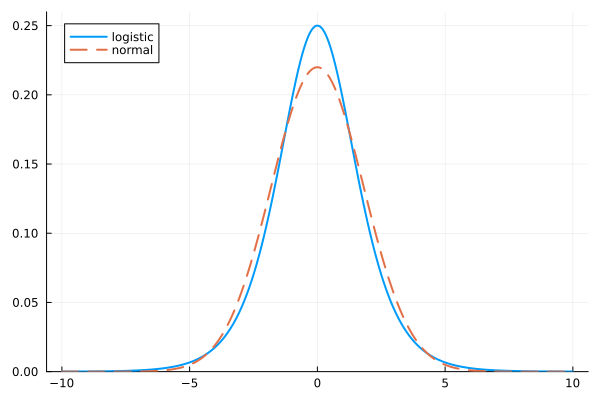

In [ ]:
pdflogistic(μ,s,x) = 1/(4s)*sech((x-μ)/(2s))^2
pdfnormal(μ,σ,x) = exp(-(x-μ)^2/(2*σ^2))/√(2π*σ^2)

μ = 0.0
s = 1.0
σ = π*s/√3
x = -10:0.02:10

P = plot(legend=:topleft, ylims=(0, 0.26))
plot!(x, pdflogistic.(μ,s,x), label="logistic", lw=2)
plot!(x, pdfnormal.(μ,σ,x),   label="normal",   lw=2, ls=:dash)

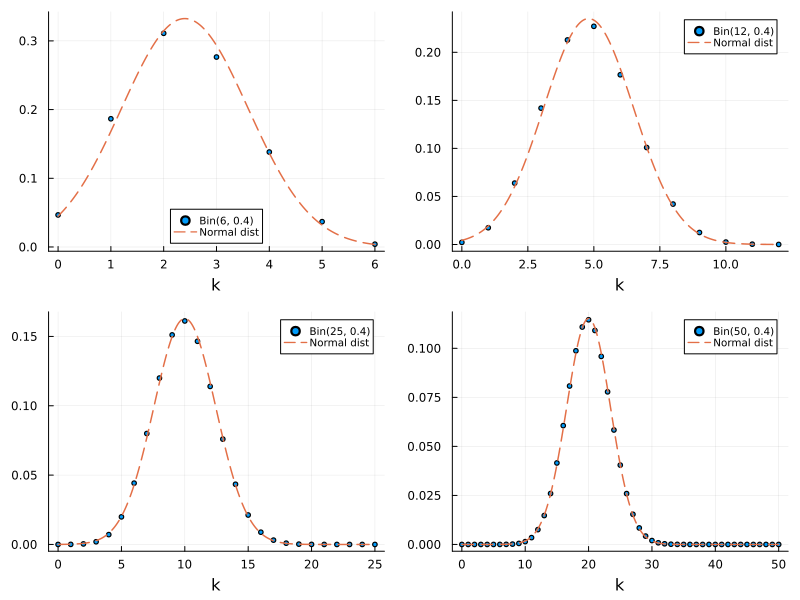

In [ ]:
binomcoeff(n,k) = exp(lgamma(n+1)-lgamma(k+1)-lgamma(n-k+1))
pdfbinom(n,p,k) = 0 ≤ k ≤ n ? binomcoeff(n,k)*p^k*(1-p)^(n-k) : 0.0
pdfnormal(n,p,x) = exp(-x^2/(2p*(1-p)))/√(2π*n*p*(1-p))

PP = []
for (n,p,l) in [(6, 0.4, :bottom), (12, 0.4, :topright), (25, 0.4, :topright), (50, 0.4, :topright)]
    k = 0:n
    kk = 0:n/400:n
    x = (kk .- n*p)./√n
    P = plot(legend=l, legendfontsize=7, xlabel="k")
    scatter!(k, pdfbinom.(n,p,k),  label="Bin($n, $p)", markersize=2.5)
    plot!(kk, pdfnormal.(n,p,x), label="Normal dist", lw=1.5, ls=:dash)
    push!(PP, P)
end
plot(PP..., size=(800, 600))

In [ ]:
using Distributions
using KernelDensity
using Printf
using Roots
using StatsFuns
using StatsPlots
default(fmt=:png)

# Wald's method for log RR

safediv(x, y) = x == 0 ? zero(x/y) : isinf(y) ? zero(y) : x/y
safemul(x, y) = x == 0 ? zero(x/y) : isinf(x) ? oftype(x, Inf) : x*y
riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)
stderr_logriskratiohat(a, b, c, d) = √(1/a - 1/(a+b) + 1/c - 1/(c+d))

function pvalue_rr_wald(a, b, c, d; ρ=1)
    (a+b==0 || c+d==0) && return 1.0
    logRRhat = log(riskratiohat(a, b, c, d))
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    2ccdf(Normal(0, 1), safediv(abs(logRRhat - log(ρ)), SEhat_logRRhat))
end

function confint_rr_wald(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0) && return [0, Inf]
    z = quantile(Normal(), 1-α/2)
    RRhat = riskratiohat(a, b, c, d)
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    [safemul(exp(-z*SEhat_logRRhat), RRhat), safemul(exp(z*SEhat_logRRhat), RRhat)]
end

function pvalue_rr_wald_onesided(a, b, c, d; ρ=1)
    (a+b==0 || c+d==0) && return 1.0
    logRRhat = log(riskratiohat(a, b, c, d))
    SEhat_logRRhat = stderr_logriskratiohat(a, b, c, d)
    cdf(Normal(0, 1), safediv(logRRhat - log(ρ), SEhat_logRRhat))
end

# score method for RR (使わない)

_riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)

# ((a-Δ)/(a-Δ+b))/((c+Δ)/(c+Δ+d)) = ρ if Δ = Delta(a, b, c, d; ρ)
function Delta(a, b, c, d; ρ=1.0)
    m, n = a+b, c+d
    A, B, C = ρ-1, n-a+ρ*(m-c), a*n-ρ*m*c
    Δ = isinf(ρ) ? oftype(ρ, -c) : ρ==0 ? oftype(ρ, a) : safediv(2C, B + √(B^2 - 4A*C))
end

function _chisqstat_rr(a, b, c, d, Δ)
    m, n = a+b, c+d
    safemul(Δ^2, safediv(b, m*(a-Δ)) + safediv(d, n*(c+Δ)))
end

function chisqstat_rr(a, b, c, d; ρ=1.0)
    Δ = Delta(a, b, c, d; ρ)
    _chisqstat_rr(a, b, c, d, Δ)
end

function pvalue_rr_score(a, b, c, d; ρ=1.0)
    χ² = chisqstat_rr(a, b, c, d; ρ)
    ccdf(Chisq(1), χ²)
end

function confint_rr_score(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0.0, Inf]
    f(logρ) = logit(pvalue_rr_score(a, b, c, d; ρ=exp(logρ))) - logit(α)
    L = if f(-Inf) > 0
        -Inf
    else
        logRRhat = log(_riskratiohat(a, b, c, d))
        x0 = logRRhat == -Inf ? -10.0 : logRRhat == Inf ? 10.0 : logRRhat - 1
        find_zero(f, x0)
    end
    U = if f(Inf) > 0
        Inf
    else
        logRRhat = log(_riskratiohat(a, b, c, d))
        x0 = logRRhat == -Inf ? -10.0 : logRRhat == Inf ? 10.0 : logRRhat + 1
        find_zero(f, x0)
    end
    [exp(L), exp(U)]
end

# Bayesian method

_ecdf(A, x) = count(≤(x), A) / length(A)

function posterior_pdf_rr(a, b, c, d;
        prior1=(1, 1), prior2=(1, 1), L=10^6)
    posterior1 = Beta((prior1 .+ (a, b))...)
    posterior2 = Beta((prior2 .+ (c, d))...)
    P = rand(posterior1, L)
    Q = rand(posterior2, L)
    RR = P ./ Q
    ik = InterpKDE(kde(RR))
    pdf_rr(x) = pdf(ik, x)
    pdf_rr
end

function posterior_pvalue_function_rr_eti(a, b, c, d;
        prior1=(1, 1), prior2=(1, 1), L=10^6)
    posterior1 = Beta((prior1 .+ (a, b))...)
    posterior2 = Beta((prior2 .+ (c, d))...)
    P = rand(posterior1, L)
    Q = rand(posterior2, L)
    RR = P ./ Q
    pvalue_rr_eti(x) = (p = _ecdf(RR, x); min(2p, 2(1-p)))
    pvalue_rr_eti
end

function posterior_onesided_pvalue_function_rr(a, b, c, d;
        prior1=(1, 1), prior2=(1, 1), L=10^6)
    posterior1 = Beta((prior1 .+ (a, b))...)
    posterior2 = Beta((prior2 .+ (c, d))...)
    P = rand(posterior1, L)
    Q = rand(posterior2, L)
    RR = P ./ Q
    onesided_pvalue_rr(x) = 1 - _ecdf(RR, x)
    onesided_pvalue_rr
end

function posterior_credint_function_rr(a, b, c, d;
        prior1=(1, 1), prior2=(1, 1), L=10^6)
    posterior1 = Beta((prior1 .+ (a, b))...)
    posterior2 = Beta((prior2 .+ (c, d))...)
    P = rand(posterior1, L)
    Q = rand(posterior2, L)
    RR = P ./ Q
    credint_rr(α=0.05) = [quantile(RR, α/2), quantile(RR, 1-α/2)]
    credint_rr
end

# HDI version (使わない)

function posterior_pvalue_function_rr_hdi(a, b, c, d;
        prior1=(1, 1), prior2=(1, 1), L=10^6)
    posterior1 = Beta((prior1 .+ (a, b))...)
    posterior2 = Beta((prior2 .+ (c, d))...)
    P = rand(posterior1, L)
    Q = rand(posterior2, L)
    logRR = log.(sort(P ./ Q))
    ik = InterpKDE(kde(logRR))
    pdf_logrr(x) = pdf(ik, x)
    function pvalue_rr_hdi(ρ)
        pdf_logrr_logρ = pdf_logrr(log(ρ))
        i1 = findfirst(x -> pdf_logrr(x) > pdf_logrr_logρ, logRR)
        i2 = findlast(x -> pdf_logrr(x) > pdf_logrr_logρ, logRR)
        1 - (i2-i1)/L
    end
    pvalue_rr_hdi
end

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


posterior_pvalue_function_rr_hdi (generic function with 1 method)

In [ ]:
function plot_ABtest(a, b, c, d;
        ρmin=0.5, ρmax=1.8, ρtick=0.1:0.1:3,
        prior1=(1, 1), prior2=(1, 1), correct_by_prior=true,
    )
    if correct_by_prior
        (aa, bb) = (a-1, b-1) .+ prior1
        (cc, dd) = (c-1, d-1) .+ prior2
    else
        aa, bb, cc, dd = a, b, c, d
    end

    @printf("Wald     95%% confident interval of success rate ratio = [%.3f, %.3f]\n",
        confint_rr_wald(aa, bb, cc, dd)...)
    #@printf("score    95%% confident interval of success rate ratio = [%.3f, %.3f]\n",
    #    confint_rr_score(aa, bb, cc, dd)...)
    @printf("Bayesian 95%% credible  interval of success rate ratio = [%.3f, %.3f]\n",
        posterior_credint_function_rr(a, b, c, d; prior1, prior2)()...)
    println()

    f1(ρ) = pvalue_rr_wald(aa, bb, cc, dd; ρ)
    g1 = posterior_pvalue_function_rr_eti(a, b, c, d; prior1, prior2)
    #f2(ρ) = pvalue_rr_score(aa, bb, cc, dd; ρ)
    #g2 = posterior_pvalue_function_rr_hdi(a, b, c, d; prior1, prior2)

    P = plot(f1, ρmin, ρmax; label="Wald method")
    plot!(g1, ρmin, ρmax; label="Bayesian method (ETI)", c=2, ls=:dash)
    #plot!(f2, ρmin, ρmax; label="score method", c=3, ls=:dot)
    #plot!(g2, ρmin, ρmax; label="Bayesian (HDI)", c=4, ls=:dashdot)
    plot!(xtick=ρtick, ytick=0:0.05:1)
    plot!(xguide="hypothetical success rate ratio ρ",
        yguide="P-value", guidefontsize=10)
    title!("frequentist and Bayesian\nP-value functions of success rate ratio",
        titlefontsize=11)

    h = posterior_pdf_rr(a, b, c, d; prior1, prior2)
    Q = plot(h, ρmin, ρmax; label="", c=2)
    plot!(xtick=ρtick)
    plot!(xguide="hypothetical success rate ratio ρ",
        yguide="probability density", guidefontsize=10)
    title!("posterior density function of success rate ratio",
        titlefontsize=11)

    F(ρ) = pvalue_rr_wald_onesided(aa, bb, cc, dd; ρ)
    G = posterior_onesided_pvalue_function_rr(a, b, c, d; prior1, prior2)

    R = plot(F, ρmin, ρmax; label="Wald method\none-sided P-value of SRR≥ρ")
    plot!(G, ρmin, ρmax; label="Bayesian method\nposterior probability of SRR≥ρ", c=2, ls=:dash)
    plot!(xtick=ρtick, ytick=0:0.05:1)
    plot!(xguide="hypothetical success rate ratio ρ",
        yguide="one-sided P-value", guidefontsize=10)
    title!("frequentist and Bayesian\none-sided P-value functions of success rate ratio",
        titlefontsize=11)

    plot(P, R, Q; size=(700, 1000), layout=(3, 1))
    plot!(leftmargin=10Plots.mm, tickfontsize=7, legendfontsize=10)
    plot!(plot_title="data=[
b;
d]\nprior1=Beta
prior2, correct_by_prior=$correct_by_prior",
        plot_titlefontsize=11)
end

plot_ABtest (generic function with 1 method)

Wald     95% confident interval of success rate ratio = [0.855, 1.392]
Bayesian 95% credible  interval of success rate ratio = [0.855, 1.391]



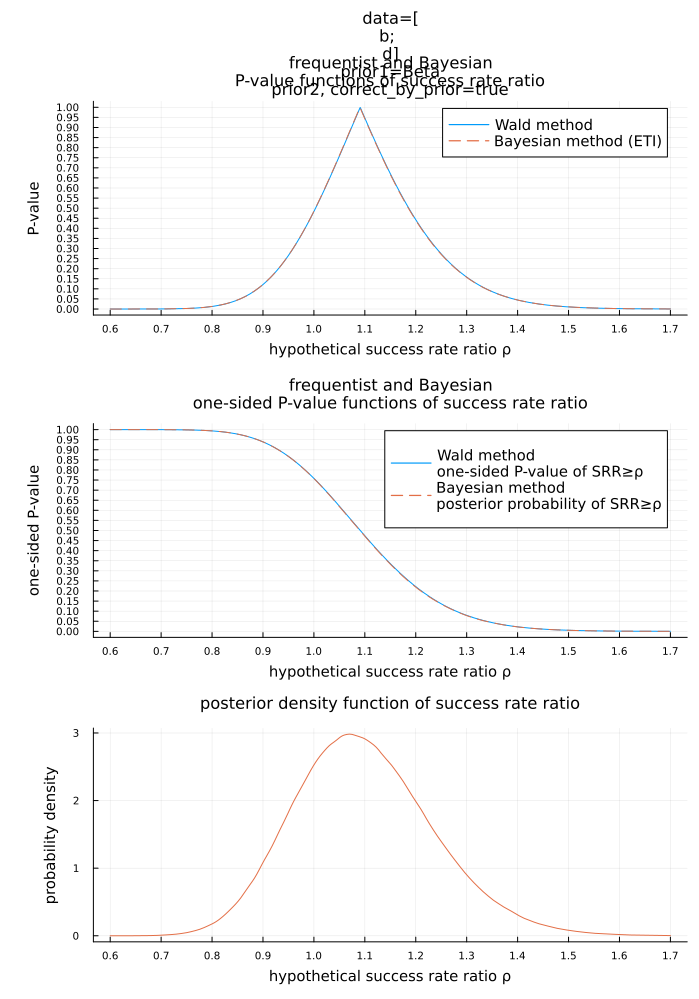

In [ ]:
a, b, c, d = 120, 1000-120, 110, 1000-110
ρmin, ρmax = 0.6, 1.7
ρtick = 0.1:0.1:3
plot_ABtest(a, b, c, d; ρmin, ρmax, ρtick)